In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import HTML

In [2]:

import numpy as np
import os
import data_utils
import pickle
import attacks
import random
from keras.models import load_model

Using TensorFlow backend.


In [3]:
TOKENIZER_PATH = 'tokenizer.pickle'
TEXT_DATA_DIR = '20_newsgroup/'
MODEL_PATH = '20news_model.h5'

In [28]:
tokenizer, inverse_tokenizer = data_utils.load_tokenizer(TOKENIZER_PATH)
model = load_model(MODEL_PATH)
labels =  list(sorted(os.listdir(TEXT_DATA_DIR)))

In [33]:
sample_file, true_label = data_utils.pick_random_file(TEXT_DATA_DIR)
file_text = data_utils.load_textfile(sample_file)
file_features = data_utils.process_text(tokenizer, file_text)

In [45]:
pred_scores = model.predict(file_features)
orig_prediction = np.argmax(pred_scores[0])
print('TrueLabel = %s' %true_label)
print('Predicted "%s" with %f .' %(labels[orig_prediction], pred_scores[0][orig_prediction]))

TrueLabel = talk.religion.misc
Predicted "talk.religion.misc" with 0.187333 .


## Randomised Attack (Non-targeted)

 Random attack will pick and replace words randomly.

In [55]:
num_words = len(tokenizer.word_index)
random_attack = attacks.RandomAttack(model, num_words)


In [56]:
x_orig = file_features.copy()
x_adv, prob_history, adv_pred = random_attack.attack(x_orig,limit=0.9)

Attack succeeded after 297 iterations.
Original class: talk.religion.misc, Attack class: rec.motorcycles
Number of changed words = 113 (89.68 %)


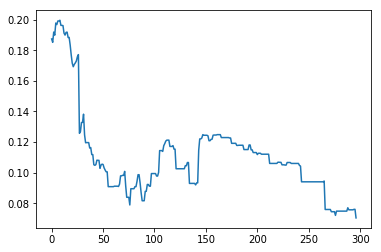

In [57]:
if x_adv is None:
    print('Attack failed. !')
else:
    print('Attack succeeded after %d iterations.' %(len(prob_history)))
    print('Original class: %s, Attack class: %s' %(labels[orig_prediction], labels[adv_pred]))
    print("Number of changed words = %d (%0.2f %%)"
          %(np.count_nonzero(x_adv != x_orig),
            100*(np.count_nonzero(x_adv != x_orig))/np.count_nonzero(x_orig)))
    plt.plot(prob_history)

## Reconstruct Text Document

In [58]:
orig_text = data_utils.reconstruct_text(inverse_tokenizer, file_features[0])
adv_text = data_utils.reconstruct_text(inverse_tokenizer, x_adv[0])

## Visualize Attack

In [59]:
orig_html, adv_html = data_utils.render_attack(orig_text, adv_text)

In [60]:
HTML("<b> Original Text </b>")
HTML(orig_html)

In [61]:
HTML("<b> Adversarial Text </b>")
HTML(adv_html)

## Evaluation

In [62]:
random_files = [data_utils.pick_random_file(TEXT_DATA_DIR) for _ in range(2000)]

In [63]:
files_, topics = zip(*random_files)

In [64]:
num_words = len(tokenizer.word_index)
random_attack = attacks.RandomAttack(model, num_words)

In [65]:
failed_cnt = 0
success_cnt = 0
dist_list = []
attack_list = []
attack_matrix = np.zeros((len(labels), len(labels)))
for idx in range(len(files_)):
    f_name = files_[idx]
    f_label = topics[idx]
    x_test = data_utils.load_textfile(f_name)
    x_orig = data_utils.process_text(tokenizer, x_test)
    x_adv,_,_ = random_attack.attack(x_orig)
    orig_pred = np.argmax(model.predict(x_orig))

    if idx % 50 == 0:
        print(idx)
    if x_adv is None:
        failed_cnt += 1
        attack_matrix[orig_pred, orig_pred] += 1
    else:
        adv_pred = np.argmax(model.predict(x_adv))
        attack_matrix[orig_pred, adv_pred] += 1
        success_cnt += 1
        dist_list.append(np.count_nonzero(x_adv != x_orig) / np.count_nonzero(x_orig))
    
    
    

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


In [66]:
print('Percentage of success = %.2f %%' %(100.0 * success_cnt / 2000))

Percentage of success = 44.40 %


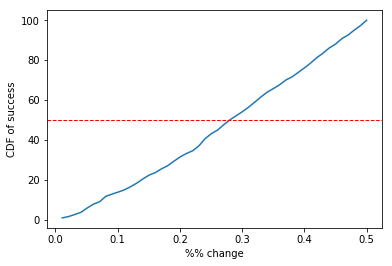

In [68]:
# Plot CDF
num_bins = 50
counts, bin_edges = np.histogram(dist_list, bins=num_bins, density=False)
cdf = np.cumsum(counts)
cdf = cdf / success_cnt
plt.plot(bin_edges[1:], cdf*100)
plt.axhline(y=50,linewidth=1, color='r', linestyle='--')
plt.xlabel('%% change')
plt.ylabel('CDF of success')
plt.savefig('cdf_random.png')

In [69]:
import seaborn as sns; sns.set()
import matplotlib

In [70]:
attack_sums = np.sum(attack_matrix, axis=1).reshape((-1,1))
attack_p = attack_matrix / attack_sums

/home/malzantot/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


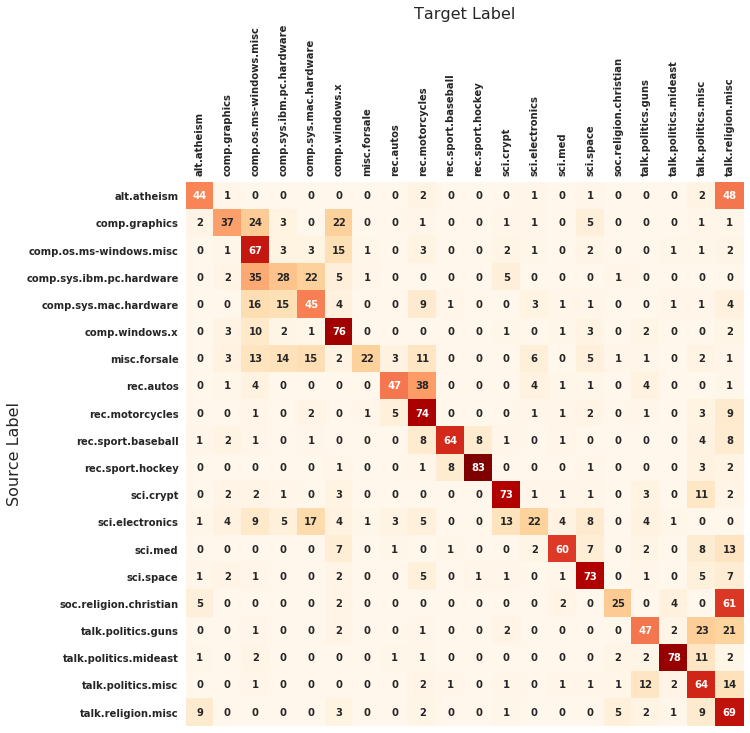

In [81]:
#sns.palplot(sns.color_palette("RdBu_r", 7)) Label
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=((10,10)))
attack_perc = (100*attack_p)
sns.heatmap(attack_perc, annot=True, fmt="0.0f",
            yticklabels=labels, xticklabels=labels, cbar=False, cmap="OrRd"
           
           )
plt.xlabel('Target Label', fontsize=16)
plt.ylabel('Source Label', fontsize=16)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)
plt.savefig('random_heatmap.png')